В ноутбуке baseline я написал просто работающую модель. В этом ноутбуке я постарался ее немого улучшить.

Во первых, нужно подумать, как валидироваться. У меня есть теория, что две посылки в день неслучайны + уж слишком все хорошо на паблик лидерборде. Поэтому я решил разделить данные на две части, сохранив баланс классов при помощи StratifiedShuffleSplit, оставив на test 20% всей выборки.

Так же я решил добавить дополнительные признаки - последние 2 и 3 символа в слове. Я попробовал 2 метода: добавлял окончания как есть, и добавлял "информативные" окончания, заменяя неинформативные на NaN. "Информативные" окончания встечаются более чем в 100 словах и при этом в одном из двух классов не реже, чем в 70%. На моей валидации победил второй вариант.

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train['Word'] = train['Word'].apply(lambda x: x.lower())
test['Word'] = test['Word'].apply(lambda x: x.lower())

#удалим дубликаты и мусор
train.drop_duplicates(inplace = True)
train = train.loc[~train.Word.isin(set(train[train.Label == 1].Word.values) & set(train[train.Label == 0].Word.values))] 

#sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#ind = list(sss.split(X=np.zeros(len(train)), y=train.Label.values))[0]
#train_ind = ind[0]
#test_ind = ind[1]

#test = train.iloc[test_ind]
#train = train.iloc[train_ind]

ss = pd.read_csv('sample_submission.csv')

In [5]:
########генерим фичи

In [6]:
###пары

In [7]:
#добавим окончаний
for i in [2,3]:
    train[f'{i}g'] = train['Word'].apply(lambda s: s[-i:])

In [8]:
#информативные пары
#.sum().Label это количество слов первого класса с этим окончанием
#.count().Label это всего слов с этим окончанием
tdf = train.set_index('Word')
df = tdf.set_index('2g').loc[(tdf.groupby('2g').count().Label>200) \
                             & (( tdf.groupby('2g').sum().Label / tdf.groupby('2g').count().Label > 0.7)| \
                                (tdf.groupby('2g').sum().Label / tdf.groupby('2g').count().Label < 0.3))]
l2 = list(set(df.index.tolist()))

df = tdf.set_index('3g').loc[(tdf.groupby('3g').count().Label>100) \
                             & (( tdf.groupby('3g').sum().Label / tdf.groupby('3g').count().Label > 0.7)| \
                                (tdf.groupby('3g').sum().Label / tdf.groupby('3g').count().Label < 0.3))]
l3 = list(set(df.index.tolist()))

d_l2 = {s:i for i,s in enumerate(l2)}
d_l3 = {s:i for i,s in enumerate(l3)}

In [9]:
########

In [10]:
train['2g'] = train['2g'].apply(lambda s: d_l2[s] if s in d_l2.keys() else np.nan)
train['3g'] = train['3g'].apply(lambda s: d_l3[s] if s in d_l3.keys() else np.nan)

for i in [2,3]:
    test[f'{i}g'] = test['Word'].apply(lambda s: s[-i:])
    
test['2g'] = test['2g'].apply(lambda s: d_l2[s] if s in d_l2.keys() else np.nan)
test['3g'] = test['3g'].apply(lambda s: d_l3[s] if s in d_l3.keys() else np.nan)

In [11]:
########

In [12]:
#я немного поменял параметры исходя из результатов моей валидации
#n - количество первых букв - фич в слове
#слова длиннее m по умолчанию считаем не фамилиями
n = 10
m = 15
list_of_features = [f'feature_{i}' for i in range(n)] + ['2g','3g']

features = train['Word'].apply(lambda s: \
                                [ord(i) for i in s[:min(len(s),n)]] + [None for i in range(max(0,n-len(s)))]).tolist()
train.reset_index(drop=True, inplace=True)
train = train.join(pd.DataFrame(features, columns=[f'feature_{i}' for i in range(n)]))

x_train = train[list_of_features]
y_train = train[['Label']]

x_train.fillna(np.nan, inplace=True)
dtrain = xgb.DMatrix(x_train, y_train)

/home/kondrat/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [13]:
#так же исходя из моей валидации я потюнил xgb "руками"
#к следующему разу постараюсь написать код, который будет делать gridsearch за меня
import xgboost as xgb
xgb_params = {
    'eta': 0.8,
    'base_score': 0.1,
    'max_depth': 6,
    'subsample': 0.6,
    'colsample_bytree': 0.7,
    'colsample_bylevel': 0.7,
    'scale_pos_weight': 2,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'silent': 0,
    #'gamma': 0.3
}


In [1269]:
num_boost_round = 1500
model = xgb.train(xgb_params, dtrain, num_boost_round = num_boost_round)

In [1275]:
#взглянем на важность признаков
#странно, что 2g не на первом месте, возможно параметры подобраны не совсем удачно
sorted(model.get_fscore().items(), key=operator.itemgetter(1), reverse=True)

[('feature_0', 9048),
 ('feature_2', 8812),
 ('feature_3', 8547),
 ('2g', 7920),
 ('feature_4', 7823),
 ('feature_1', 7187),
 ('feature_5', 6527),
 ('feature_6', 5130),
 ('3g', 4658),
 ('feature_7', 3356),
 ('feature_8', 1763),
 ('feature_9', 1003)]

In [1271]:
#попробуем предсказывать все
test_df = test[['Word']]
test_df.loc[test_df.Word.apply(len) > m, 'Label'] = 0

features = test['Word'].apply(lambda s: \
                                [ord(i) for i in s[:min(len(s),n)]] + [None for i in range(max(0,n-len(s)))]).tolist()
#получим предикты
test_df = test_df.join(pd.DataFrame(features, columns=[f'feature_{i}' for i in range(n)]))

index_to_pred = test_df.Label.isnull()
dtest = xgb.DMatrix(test_df.loc[index_to_pred, list_of_features])
y_predict = model.predict(dtest)

#coберем все воедино
test_df.loc[index_to_pred, 'Label'] = y_predict
test_df = test_df['Label'].reset_index()
test_df.columns = ss.columns
test_df.to_csv('base_2_3.csv',index = False)

/home/kondrat/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/kondrat/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [2]:
##############

In [ ]:
#посмотрим на распределение предсказаний

In [1273]:
test_df[['Prediction']].describe()

,Prediction
count,188920.000000
mean,0.127621
std,0.282280
min,0.000000
25%,0.000005
50%,0.000620
75%,0.040208
max,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f700420ec88>]], dtype=object)

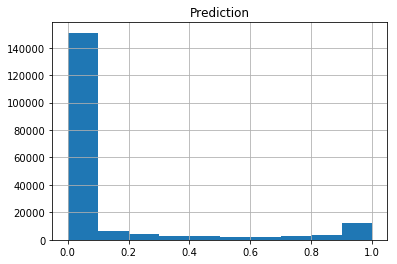

In [1274]:
test_df[['Prediction']].hist()

In [ ]:
auc = roc_auc_score(y_true=test.loc[test_df.Id, 'Label'].values, y_score = test_df.Prediction.values)
auc

In [1306]:
#добавим ответы из test, причем те, и только те, 
#которые не противоречат друг другу (встречаются только с 1 значением Label) 
temp_test_df = test_df.set_index('Word').join(train[['Word','Label']].set_index('Word')).reset_index()
temp_test_df.loc[~temp_test_df.Label.isnull(),'Prediction'] = temp_test_df[~temp_test_df.Label.isnull()]['Label']
temp_test_df.drop(['Word', 'Label'],axis = 1, inplace=True)
temp_test_df.columns = ss.columns
temp_test_df.to_csv('train_base_2_3.csv',index = False)

Эти решения набрали на public leaderboard ~0.81 и 0.79 соответсвенно, что хуже, чем baseline.

In [896]:
##################